# Loss of Function Variants in GnomAD Populations

We'd like to estimate what genes are enriched for loss of function (LoF) variants
in specific GnomAD populations relative to non-Finnish Europeans (NFE). Since we 
are interested in LoF variants, I'm looking at the GnomAD exome VCF file.

We'll use the PIEMM model introduced in http://biorxiv.org/content/early/2016/09/25/077180. 

In [1]:
import cPickle
import os

import matplotlib as mpl

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
import scipy.stats as stats
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Helvetica'] + plt.rcParams['font.sans-serif']

from IPython.display import display, HTML

%matplotlib inline
%load_ext rpy2.ipython

outdir = '../output/lof_enrichment_analysis'
if not os.path.exists(outdir):
    os.makedirs(outdir)
private_outdir = '../private_output/lof_enrichment_analysis'
if not os.path.exists(private_outdir):
    os.makedirs(private_outdir)

In [2]:
%%R

source("../scripts/PIEMM.r")

In [3]:
# Bring piemm function into python.
piemm_fnc = robjects.r['piemm']

def piemm(betas, ses, priorvar0=0.3**2, paramfix=True, var1fix=1, var2fix=1):
    """Wrapper around R piemm function."""
    res = piemm_fnc(betas, ses, paramfix=paramfix, priorvar0=priorvar0, var1fix=var1fix, var2fix=var2fix)
    mu = pd.DataFrame(pandas2ri.ri2py(res[0]))
    pi = pd.DataFrame(pandas2ri.ri2py(res[1]))
    sigma = pd.DataFrame(pandas2ri.ri2py(res[2]))
    gamma = pd.DataFrame(pandas2ri.ri2py(res[3]))
    meansd = pd.Series(pandas2ri.ri2py(res[4]))
    meanpi = pd.Series(pandas2ri.ri2py(res[5]))
    meanmu = pd.Series(pandas2ri.ri2py(res[6]))
    l95sd = pd.Series(pandas2ri.ri2py(res[7]))
    l95pi = pd.Series(pandas2ri.ri2py(res[8]))
    l95mu = pd.Series(pandas2ri.ri2py(res[9]))
    u95sd = pd.Series(pandas2ri.ri2py(res[10]))
    u95pi = pd.Series(pandas2ri.ri2py(res[11]))
    u95mu = pd.Series(pandas2ri.ri2py(res[12]))

    ires = pd.Panel({'mu':mu, 'sigma': sigma, 'pi':pi})
    ores = pd.DataFrame({'meanmu':meanmu, 'meansd':meansd, 'meanpi':meanpi, 
                         'l95mu':l95mu, 'l95sd':l95sd, 'l95pi':l95pi,
                         'u95mu':u95mu, 'u95sd':u95sd, 'u95pi':u95pi})
    return ires, ores, gamma

def calc_summary_stats(df, popb, popa='NFE'):    
    lofa = df['AC_{}'.format(popa)]
    not_lofa = df['AN_{}'.format(popa)] - lofa
    lofb = df['AC_{}'.format(popb)]
    not_lofb = df['AN_{}'.format(popb)] - lofb
    
    beta = np.log(((0.5 + not_lofa) * (0.5 + lofb)) / ((0.5 + lofa) * (0.5 + not_lofb)))
    stderr2 = 1 / (0.5 + not_lofa) + 1 / (0.5 + not_lofb) + 1 / (0.5 + lofa) + 1 / (0.5 + lofb)
    
    ss = pd.DataFrame({'beta':beta, 'se2':stderr2})
    
    return ss

def estimate_af_bayesian(ac, an, pop, a=1, b=100):
    """
    ac is allele counts, an is the total number of genotypes. These should be
    pandas Series.
    """
    af = (a + ac) / (a + b + an)
    # Credible interval is 95% highest posterior density
    ci = pd.DataFrame(
        dict(zip(['AF_bayes_ci_lower_{}'.format(pop), 
                  'AF_bayes_ci_upper_{}'.format(pop)], 
                  stats.beta(a + ac, b + an - ac).interval(0.95))),
        index=af.index)
    out = pd.DataFrame({'AF_bayes_{}'.format(pop):af}).join(ci)
    return(out)

In [4]:
fn = '/srv/gsfs0/projects/rivas/data/gencode.v19_20170302/parsing/gencode.v19.annotation.table.tsv'
if not os.path.exists(fn):
    fn = '/oak/stanford/groups/mrivas/public_data/gencode.v19_20170526/parsing/gencode.v19.annotation.table.tsv'
gtable = pd.read_table(fn, index_col=0)
gtable['gencode_id'] = gtable.index
gtable.index = [x.split('.')[0] for x in gtable.index]

In [5]:
fn = '/srv/gsfs0/projects/rivas/data/gnomad_170228_20170228/parsing/gnomad.exomes.r2.0.1.sites.lof.tsv'
if not os.path.exists(fn):
    fn = '/oak/stanford/groups/mrivas/public_data/gnomad_20170525/parsing/gnomad.exomes.r2.0.1.sites.tsv'
vrs = pd.read_table(fn,
                    dtype={'CHROM':str, 'POS':int, 'REF':str, 'ALT':str, 'AC_AFR':int, 'AC_AMR':int, 
                           'AC_ASJ':int, 'AC_EAS':int, 'AC_FIN':int, 'AC_NFE':int, 'AC_OTH':int, 
                           'AC_SAS':int, 'AN_AFR':int, 'AN_AMR':int, 'AN_ASJ':int, 'AN_EAS':int, 
                           'AN_FIN':int, 'AN_NFE':int, 'AN_OTH':int, 'AN_SAS':int, 'Allele':str,
                           'Consequence':str, 'IMPACT':str, 'Gene':str, 'BIOTYPE':str, 'SIFT':str,
                           'PolyPhen':str, 'CLIN_SIG':str, 'LoF':str, 'LoF_filter':str, 
                           'LoF_flags':str, 'LoF_info':str})
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_mle_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]

In [6]:
# Maximum number of chromosomes genotyped per population.
pop_max = vrs[['AN_{}'.format(x) for x in pops]].max()
pop_max.index = [x.split('_')[1] for x in pop_max.index]

In [7]:
pops = [x.split('_')[1] for x in vrs.columns if 'AC_' in x]
for pop in pops:
    vrs['AF_mle_{}'.format(pop)] = vrs['AC_{}'.format(pop)].astype(float) / vrs['AN_{}'.format(pop)]
    
for pop in pops:
    vrs['GP_{}'.format(pop)] = vrs['AN_{}'.format(pop)].astype(float) / pop_max[pop]
    
lof_only = vrs.dropna(subset=['LoF'])

## LoF Enrichment 

### Model

I'm going to calculate effect sizes and standard errors using the methods from http://biorxiv.org/lookup/doi/10.1101/077180. In particular, we can calculate
a bias-corrected log odds ratio and squared standard error as

$$\hat\beta_i = \log(\textrm{OR}_i) = \log\left(\frac{(0.5 + \textrm{LoF}_{a})(0.5 + \textrm{notLoF}_{b})}
{(0.5 + \textrm{notLoF}_{a})(0.5 + \textrm{LoF}_{b})}\right)$$

$$\hat{\textrm{SE}_i}^2 = \frac{1}{0.5 + \textrm{LoF}_{a}} + \frac{1}{0.5 + \textrm{LoF}_{b}}
+ \frac{1}{0.5 + \textrm{notLoF}_{a}} + \frac{1}{0.5 + \textrm{notLoF}_{b}}
$$

for a gene $i$ and two population groups $a$ and $b$. To start, I will compare all other population groups
to the non-Finnish Europeans (NFE). We are interested in how many gene copies harbor an LoF
variant in each population. 

For the LoF counts, I will sum the number of LoF alleles observed for each gene. So if a gene has
one variant site that is LoF but that allele was observed 10 times, that gene will have a count of 10.
Similarly, a gene with 10 LoF sites that are each observed once would also have a count of 10. We are 
assuming that a single person doesn't harbor two LoF variants which should be reasonable if they have
a low frequency.

### Variant filtering

I will filter out LoF variants that 

* weren't genotyped in at least 80% of the subjects for all populations
* were assigned to more than one gene
* have an allele frequency greater than 5% in any population
* are low confidence

In [8]:
for pop in pops:
    print('{:.1f}% of variants genotyped at >80% for {}.'.format(
            (vrs['GP_{}'.format(pop)] > 0.80).sum() / float(vrs.shape[0]) * 100, 
            pop))

83.5% of variants genotyped at >80% for AFR.
81.7% of variants genotyped at >80% for AMR.
87.4% of variants genotyped at >80% for ASJ.
83.8% of variants genotyped at >80% for EAS.
82.2% of variants genotyped at >80% for FIN.
83.0% of variants genotyped at >80% for NFE.
82.6% of variants genotyped at >80% for OTH.
81.8% of variants genotyped at >80% for SAS.


In [9]:
for pop in pops:
    print('{:.1f}% of LoF variants genotyped at >80% for {}.'.format(
            (lof_only['GP_{}'.format(pop)] > 0.80).sum() / float(lof_only.shape[0]) * 100, 
            pop))

86.3% of LoF variants genotyped at >80% for AFR.
85.9% of LoF variants genotyped at >80% for AMR.
92.2% of LoF variants genotyped at >80% for ASJ.
86.8% of LoF variants genotyped at >80% for EAS.
85.8% of LoF variants genotyped at >80% for FIN.
86.3% of LoF variants genotyped at >80% for NFE.
86.4% of LoF variants genotyped at >80% for OTH.
86.2% of LoF variants genotyped at >80% for SAS.


In [59]:
# Remove sites that weren't called for at least 80% of haplotypes in all populations.
lof_only_f = lof_only[lof_only[[x for x in lof_only.columns if 'GP_' in x]].min(axis=1) > 0.8]
# Remove sites that are assigned to more than one gene.
lof_only_f = lof_only_f[lof_only_f.Gene.apply(lambda x: ',' not in x)]
# Remove sites that have an allele frequency greater than 5% in any population.
lof_only_f = lof_only_f[lof_only_f[[x for x in lof_only_f.columns if 'AF_' in x]].max(axis=1) < 0.05]
# Keep only high confidence sites.
lof_only_f = lof_only_f[lof_only_f.LoF == 'HC']

### Calculate collapsed allele frequencies

I'm going to calculate collapsed (or combined) allele frequencies for each gene 
by summing up the number of of LoF alleles observed for each gene, then divide
by the number of haplotypes observed. The one complication here is that each 
variant could have a different AN. I'm just going to average the ANs for all 
the variants in a gene and divide by that number. Since I've restricted to 
variants that are genotyped in at least 80% of individuals, this should be a
pretty reasonable estimate of the AN.

In [60]:
vc = lof_only_f.Gene.value_counts()
lof_gene = lof_only_f.drop(['CHROM', 'POS', 'REF', 'ALT'] + list(lof_only.columns[-16:]), axis=1).groupby('Gene').sum()
# We need to divide the AN numbers by the number of LoF variants per gene to get the average AN.
for pop in pops:
    lof_gene['AN_{}'.format(pop)] = (lof_gene['AN_{}'.format(pop)] / vc).round()
lof_gene = lof_gene[gtable.ix[lof_gene.index, 'gene_type'] == 'protein_coding']
# Calculate MLE allele frequency estimates.
for pop in pops:
    lof_gene['AF_mle_{}'.format(pop)] = lof_gene['AC_{}'.format(pop)] / lof_gene['AN_{}'.format(pop)]
# Calculate Bayesian allele frequency estimates.
for pop in pops:
    lof_gene = lof_gene.join(estimate_af_bayesian(lof_gene['AC_{}'.format(pop)], 
                                                  lof_gene['AN_{}'.format(pop)], 
                                                  pop))

In [61]:
summary_stats = {}
tpops = list(set(pops) - set(['NFE', 'OTH']))
for pop in tpops:
    summary_stats[pop] = beta, stderr2 = calc_summary_stats(lof_gene, pop)
    
for pop in tpops:
    summary_stats[pop].to_csv(os.path.join(outdir, '{}_ss.tsv'.format(pop)), sep='\t')

### Run model

In [62]:
fn = os.path.join(outdir, 'piemm_res_01_05_05.pickle')
if os.path.exists(fn):
    piemm_res_01_05_05 = cPickle.load(open(fn))
else:
    piemm_res_01_05_05 = {}
    for pop in tpops:
        betas = summary_stats[pop]['beta']
        ses = np.sqrt(summary_stats[pop]['se2'])
        ires, ores, gamma = piemm(betas, ses, priorvar0=0.1**2, var1fix=0.05**2, var2fix=0.05**2)
        gamma.index = betas.index
        gamma = gamma / gamma.sum(axis=1).ix[0]
        piemm_res_01_05_05[pop] = [ires, ores, gamma]
        with open(fn, 'w') as f:
            cPickle.dump(piemm_res_01_05_05, f)

In [63]:
def plot_norms(mus, sigmas, ax=None, percent=0.99):
    mus = list(mus)
    sigmas = list(sigmas)
    # Define max and min.
    xmax = max([stats.norm.ppf(percent, mus[i], sigmas[i]) for i in range(len(mus))] + 
               [abs(stats.norm.ppf(1 - percent, mus[i], sigmas[i])) for i in range(len(mus))])
    xmin = -xmax
    x = np.linspace(xmin, xmax, 100)
    if ax is None:
        fig, ax = plt.subplots(1)
    for i in range(len(mus)):
        ax.plot(x, stats.norm.pdf(x, mus[i], sigmas[i]), label=i)
    ax.legend()
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group distributions')

def visualize_piemm_res(pop, piemm_res, summary_stats):
    display(HTML('<h4>Results for {}</h4>'.format(pop)))
    ires, ores, gamma = piemm_res[pop]
    sum_stats = summary_stats[pop]
    fig, axs = plt.subplots(6, 2, figsize=(10, 15))
    display(ores)
    
    plot_num = 0
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meanmu)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95mu'], ores.ix[i, 'u95mu'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\mu$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meansd)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95sd'], ores.ix[i, 'u95sd'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\sigma$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ax.scatter(range(3), ores.meanpi)
    for i in range(3):
        ax.vlines(i, ores.ix[i, 'l95pi'], ores.ix[i, 'u95pi'])
    ax.set_xticks([0, 1, 2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Posterior estimate')
    ax.set_title('$\pi$')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['mu'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\mu$')
    ax.set_title('$\mu$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['sigma'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\sigma$')
    ax.set_title('$\sigma$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    ires['pi'].plot(ax=ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('$\pi$')
    ax.set_title('$\pi$ vs. iterations')
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    plot_norms(ores.meanmu, ores.meansd, ax=ax)
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    sum_stats['group'] = gamma.idxmax(axis=1).values
    xmax = np.ceil(sum_stats.beta.abs().max())
    xmin = -xmax
    step = (xmax - xmin) / 100.
    toplot = []
    for i in [2, 0, 1]:
        toplot.append(sum_stats.ix[sum_stats.group == i, 'beta'].values)
    ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), label=[2, 0, 1], 
            color=[sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]])
    ax.set_xlabel('Beta')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of betas stratified by group membership')
    ax.legend()
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 2
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
    xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
    xmax = stats.norm.ppf(0.99, mu, sigma)
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 0
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
    xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
    xmax = stats.norm.ppf(0.99, mu, sigma)
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plot_num += 1
    ax = axs[plot_num / 2, plot_num % 2]
    
    i = 1
    tpi = {0:1, 2:0, 1:2}[i]
    mu = ores.ix[i, 'meanmu']
    sigma = ores.ix[i, 'meansd']
    xmin = stats.norm.ppf(1 - 0.99, mu, sigma)
    xmax = stats.norm.ppf(0.99, mu, sigma)
    x = np.linspace(xmin, xmax, 100)
    step = (xmax - xmin) / 100.
    ax.hist(toplot[tpi], bins=np.arange(xmin, xmax + step, step), normed=True);
    ax.plot(x, stats.norm.pdf(x, mu, sigma))
    ax.set_xlabel('Beta')
    ax.set_ylabel('Density')
    ax.set_title('Group {}'.format(i))
    
    plt.tight_layout()
    plt.show();

## Results

### var0 = $0.1^2$, var1 = var2 = $0.05^2$

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.582377,0.10,0.000000,0.594034,0.10,0.000000,0.608377,0.10
1,1.175328,0.257417,0.05,1.199587,0.265283,0.05,1.221394,0.273190,0.05
2,-1.226845,0.131439,0.05,-1.187529,0.140683,0.05,-1.143593,0.150968,0.05


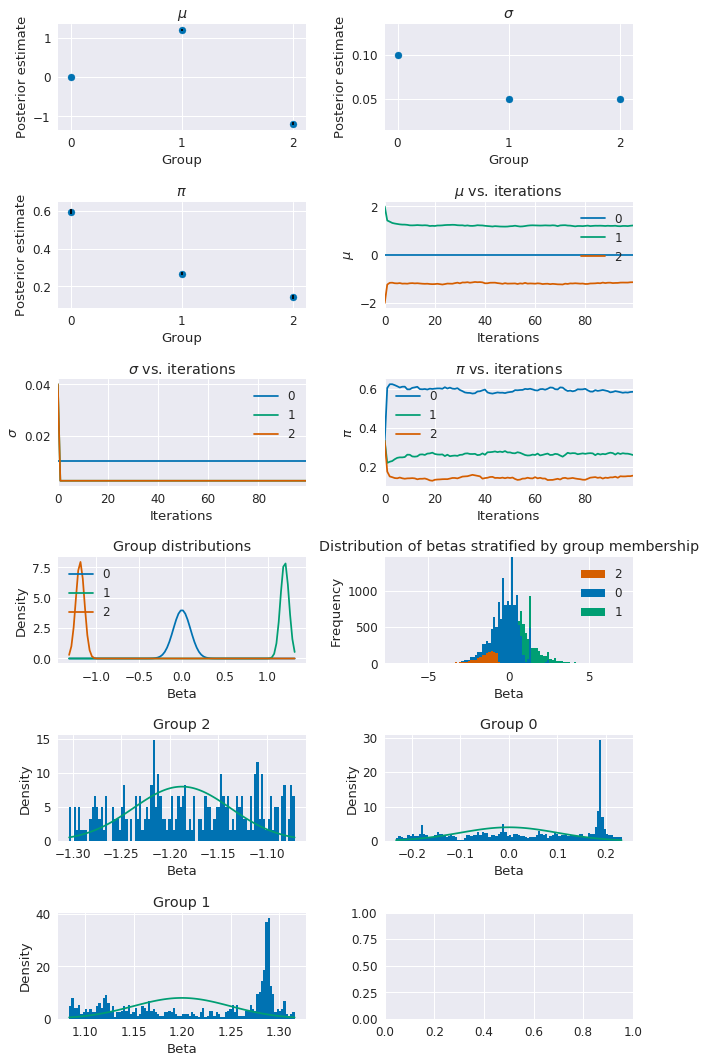

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.147647,0.10,0.000000,0.168317,0.10,0.000000,0.189282,0.10
1,0.224963,0.520800,0.05,0.248185,0.540427,0.05,0.274362,0.552778,0.05
2,-1.031458,0.280932,0.05,-0.999890,0.291256,0.05,-0.977977,0.307633,0.05


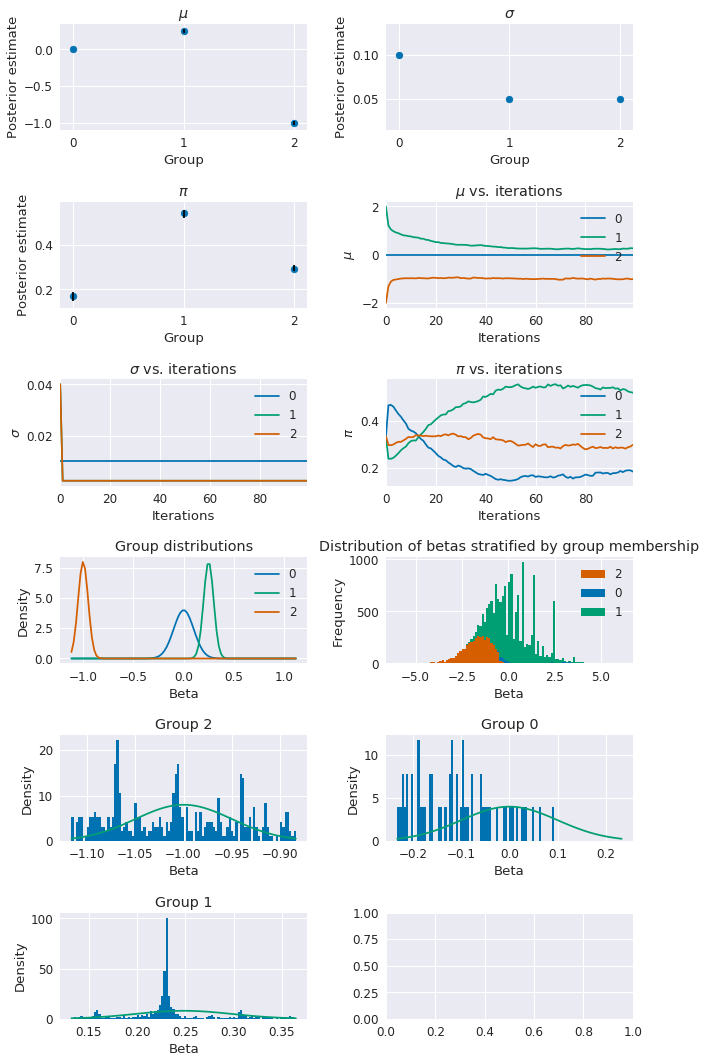

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.549348,0.10,0.000000,0.562610,0.10,0.000000,0.572687,0.10
1,1.180906,0.317090,0.05,1.207151,0.326617,0.05,1.233996,0.339346,0.05
2,-1.712031,0.105176,0.05,-1.665550,0.110773,0.05,-1.618107,0.117032,0.05


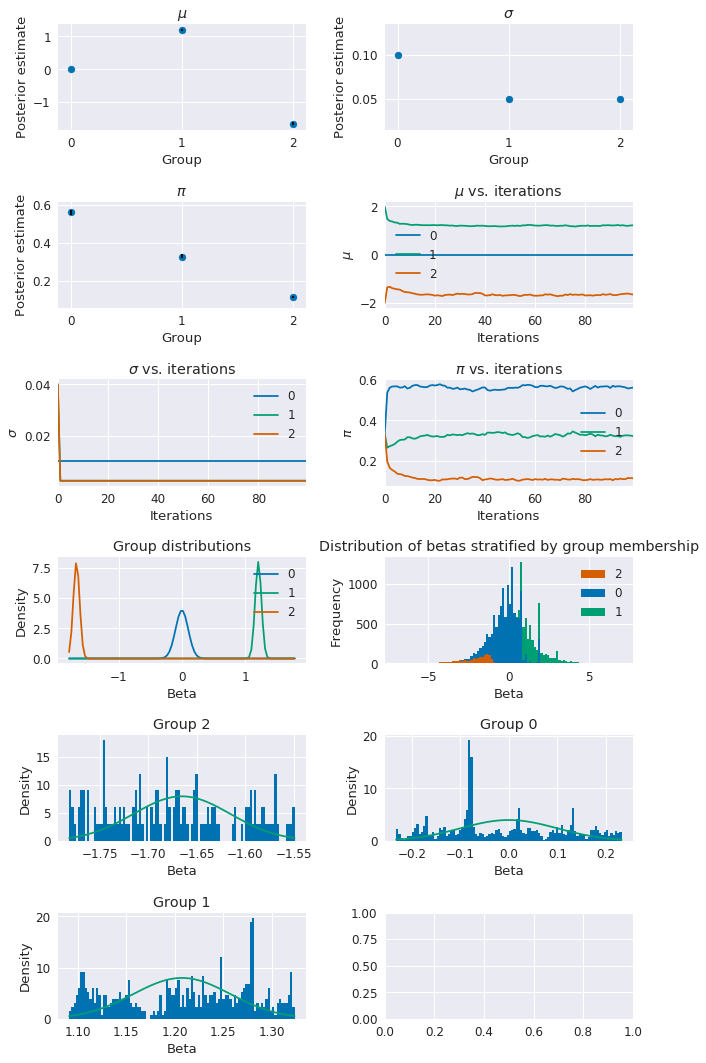

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.512197,0.10,0.000000,0.526192,0.10,0.000000,0.538026,0.10
1,0.962644,0.256475,0.05,1.005160,0.266544,0.05,1.030846,0.277479,0.05
2,-0.972984,0.197207,0.05,-0.949081,0.207265,0.05,-0.929219,0.213634,0.05


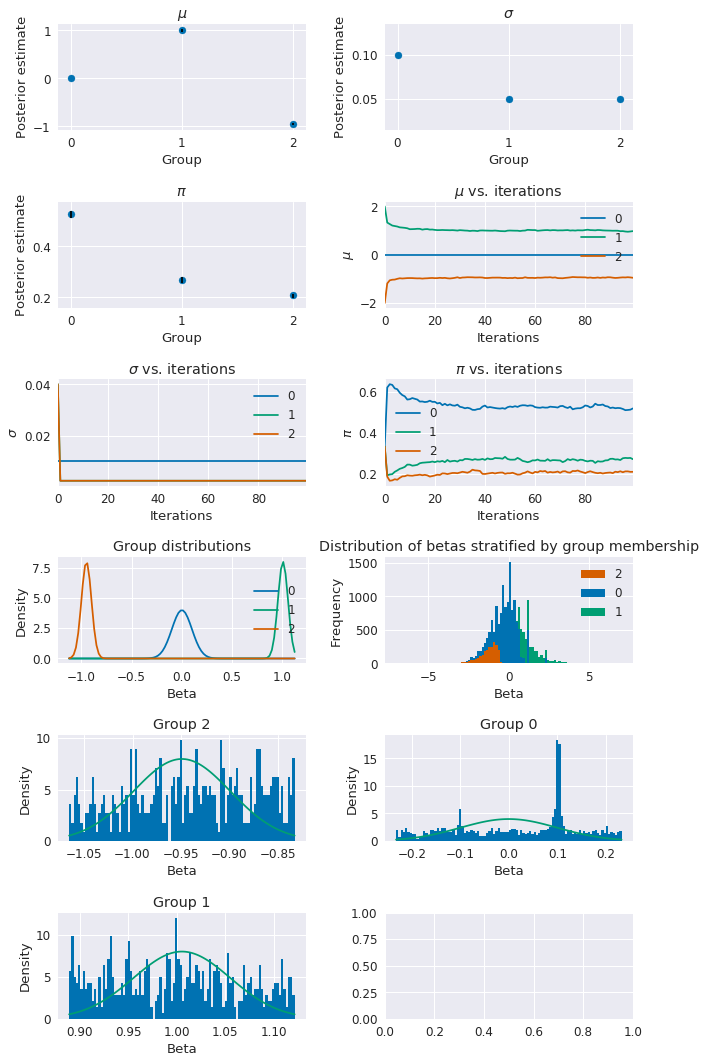

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.243372,0.10,0.000000,0.363229,0.10,0.000000,0.479841,0.10
1,0.010606,0.106342,0.05,0.196579,0.196748,0.05,0.526187,0.281142,0.05
2,-1.346698,0.410814,0.05,-1.311803,0.440023,0.05,-1.272029,0.486407,0.05


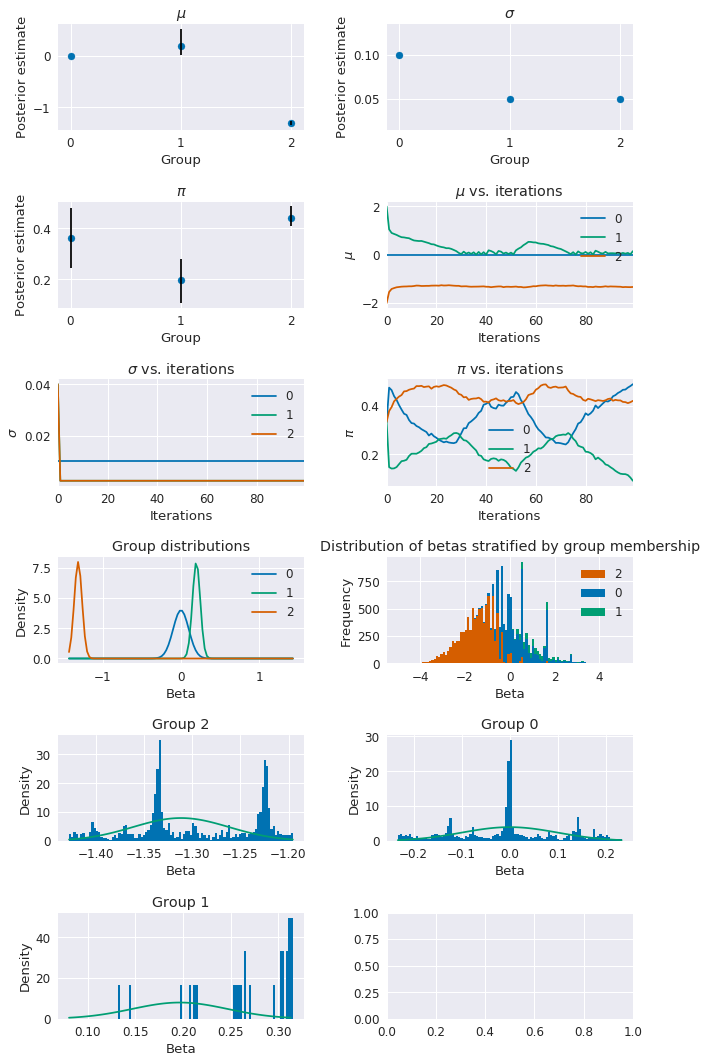

,l95mu,l95pi,l95sd,meanmu,meanpi,meansd,u95mu,u95pi,u95sd
0,0.000000,0.535808,0.10,0.000000,0.551218,0.10,0.000000,0.564005,0.10
1,1.624437,0.269165,0.05,1.656012,0.279554,0.05,1.693861,0.287690,0.05
2,-0.725287,0.158417,0.05,-0.677214,0.169228,0.05,-0.653132,0.180121,0.05


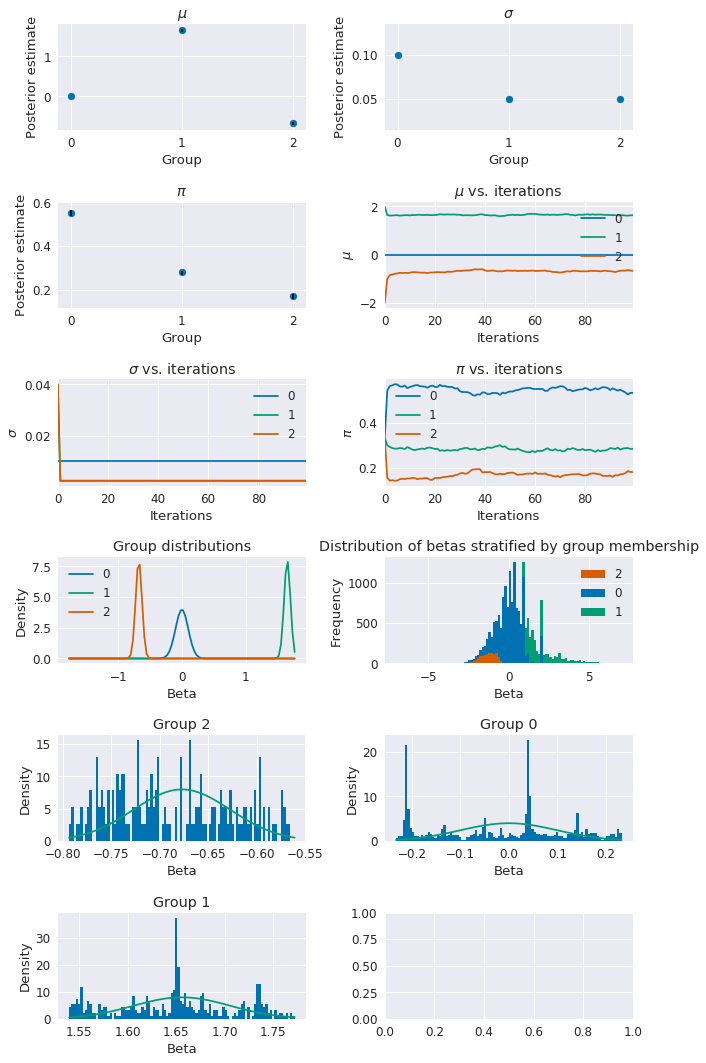

In [64]:
for pop in tpops:
    visualize_piemm_res(pop, piemm_res_01_05_05, summary_stats)

I am getting stable estimates for the large populations (AFR, AMR, EAS, SAS)
so I will focus on those.

## Compare AFR vs. AMR

I want to compare the genes enriched for LoF variants
among African ancestry and Latino ancestry individuals.

In [65]:
focus_pops = ['AFR', 'AMR', 'EAS', 'SAS']
to_remove = ['OTH']
cols_to_drop = []
for pop in to_remove:
    cols_to_drop += [x for x in lof_gene.columns if pop in x]
lof_gene = lof_gene.drop(cols_to_drop, axis=1)

In [66]:
cols = ['enriched_{}'.format(x) for x in focus_pops]
enriched = pd.DataFrame(False, index=piemm_res_01_05_05['AFR'][2].index,
                        columns=cols)
for pop in focus_pops:
    gamma = piemm_res_01_05_05[pop][2]
    enriched.ix[gamma[gamma[1] > 0.8].index, 'enriched_{}'.format(pop)] = True
    print('{:,} enriched genes for {}.'.format(
        enriched['enriched_{}'.format(pop)].sum(), pop))
enriched.to_csv(os.path.join(outdir, 'enriched.tsv'), sep='\t')

cols = ['depleted_{}'.format(x) for x in focus_pops]
depleted = pd.DataFrame(False, index=piemm_res_01_05_05['AFR'][2].index,
                        columns=cols)
for pop in focus_pops:
    gamma = piemm_res_01_05_05[pop][2]
    depleted.ix[gamma[gamma[2] > 0.8].index, 'depleted_{}'.format(pop)] = True
    print('{:,} depleted genes for {}.'.format(
        depleted['depleted_{}'.format(pop)].sum(), pop))
depleted.to_csv(os.path.join(outdir, 'depleted.tsv'), sep='\t')

lof_gene = lof_gene.merge(enriched, left_index=True, right_index=True, how='left')

2,715 enriched genes for AFR.
2,295 enriched genes for AMR.
2,692 enriched genes for EAS.
2,496 enriched genes for SAS.
733 depleted genes for AFR.
1,218 depleted genes for AMR.
850 depleted genes for EAS.
946 depleted genes for SAS.


/home/groups/mrivas/anaconda/3.5/envs/lof-enrichment/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


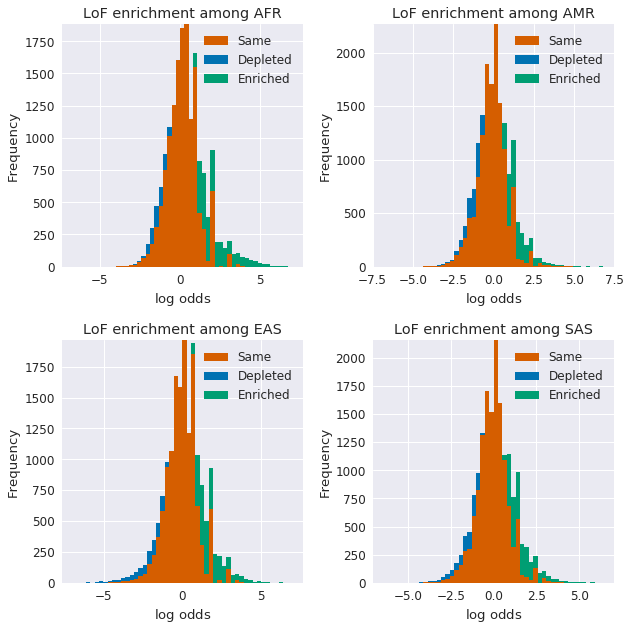

In [67]:
sns.set_palette(sns.color_palette('colorblind'))
sns.set_context('notebook', font_scale=1.2)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))

for i, pop in enumerate(focus_pops):
    ax = axs[i > 1, i % 2]
    sum_stats = summary_stats[pop]
    ires, ores, gamma = piemm_res_01_05_05[pop]
    sum_stats['group'] = gamma.idxmax(axis=1).values
    xmax = np.ceil(sum_stats.beta.abs().max())
    xmax = np.round(sum_stats.beta.abs().max(), 1) + 0.1
    xmin = -xmax
    step = (xmax - xmin) / 50.
    toplot = []
    dep = set(depleted[depleted['depleted_{}'.format(pop)]].index)
    enr = set(enriched[enriched['enriched_{}'.format(pop)]].index)
    toplot.append(sum_stats.ix[set(sum_stats.index) - dep - enr, 'beta'])
    toplot.append(sum_stats.ix[dep, 'beta'])
    toplot.append(sum_stats.ix[enr, 'beta'])
    ax.hist(toplot, stacked=True, bins=np.arange(xmin, xmax + step, step), 
            label=['Same', 'Depleted', 'Enriched'], 
            color=[sns.color_palette()[2], sns.color_palette()[0], sns.color_palette()[1]])
    ax.set_xlabel('$\log$ odds')
    ax.set_ylabel('Frequency')
    ax.set_title('LoF enrichment among {}'.format(pop))
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'afr_amr_lof_enr.pdf'))

## Annotate Genes

I'm going to annotate the genes with a few gene lists and GWAS associations.

### GWAS Genes

I'm going to use the gene-disease associations from [this](https://thinklab.com/discussion/extracting-disease-gene-associations-from-the-gwas-catalog/80). Note that I'm using the file from [this commit](https://github.com/dhimmel/gwas-catalog/commit/a5aa4910708a3995501ebe4136d8b9d601463fa1) which is ahead of master. It includes more diseases.

In [68]:
path = ('https://raw.githubusercontent.com/dhimmel/gwas-catalog/'
        'a5aa4910708a3995501ebe4136d8b9d601463fa1/data/gene-associations.tsv')
gwas_genes = pd.read_table(path)

gwas_genes_f = gwas_genes[gwas_genes.high_confidence == 1]

vc = gtable.gene_name.value_counts()
vc = vc[vc > 1]
tdf = gtable[gtable.gene_name.apply(lambda x: x not in vc.index)]
gn_to_gid = pd.Series(tdf.index, index=tdf.gene_name.values)

gwas_genes_f.loc[:, 'gene_id'] = gn_to_gid[gwas_genes_f.symbol].values
gwas_genes_f = gwas_genes_f.dropna()

# gsp_diseases = ['coronary artery disease', 'inflammatory bowel disease', 'type 1 diabetes mellitus',
#                 'asthma', 'epilepsy syndrome', 'autistic disorder']

gwas_phenotypes = pd.crosstab(index=gwas_genes_f['gene_id'], columns=gwas_genes['doid_name'])
gwas_phenotypes = gwas_phenotypes[gwas_phenotypes.columns[(gwas_phenotypes.sum() > 10)]].astype(bool)
lof_gene = lof_gene.merge(gwas_phenotypes, left_index=True, right_index=True, how='left')
lof_gene = lof_gene.replace(np.nan, False)

### Other Gene Lists

In [69]:
# I'll collect each gene list in this dict.
gene_lists = dict()

# FDA-approved drug targets
fn = ('../submodules/gene_lists/lists/fda_approved_drug_targets.tsv')
fda_drug_targets = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in fda_drug_targets.index:
    ind.append(gtable[gtable.gene_name == fda_drug_targets[i]].index[0])
fda_drug_targets.index = ind
gene_lists['fda_approved_drug_target'] = list(fda_drug_targets.index)

# Drug targets from Nelson et al.
fn = ('../submodules/gene_lists/lists/drug_targets_nelson.tsv')
nelson_drug_targets = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in nelson_drug_targets.index:
    if len(gtable[gtable.gene_name == nelson_drug_targets[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == nelson_drug_targets[i]].index[0])
    else:
        ind.append('NaN')
nelson_drug_targets.index = ind
nelson_drug_targets = nelson_drug_targets.drop('NaN')
gene_lists['nelson_drug_target'] = list(nelson_drug_targets.index)

fn = ('../submodules/gene_lists/lists/all_ar.tsv')
auto_recessive_genes = pd.read_table(fn, header=None, squeeze=True)
ind = []
for i in auto_recessive_genes.index:
    if len(gtable[gtable.gene_name == auto_recessive_genes[i]].index) > 0:
        ind.append(gtable[gtable.gene_name == auto_recessive_genes[i]].index[0])
    else:
        ind.append('NaN')
auto_recessive_genes.index = ind
auto_recessive_genes = auto_recessive_genes.drop('NaN')
gene_lists['auto_recessive'] = list(auto_recessive_genes.index)

for k in gene_lists.keys():
    lof_gene[k] = False
    lof_gene.ix[set(gene_lists[k]) & set(lof_gene.index), k] = True
    
    afr_vc = lof_gene.ix[lof_gene['enriched_AFR'], k].value_counts()
    amr_vc = lof_gene.ix[lof_gene['enriched_AMR'], k].value_counts()
    print('### {} ###'.format(k))
    print('{:,} enriched in AFR.'.format(afr_vc[1]))
    print('{:,} enriched in AMR.'.format(amr_vc[1]))
    n = lof_gene[lof_gene['enriched_AFR'] & lof_gene['enriched_AMR'] & 
                 lof_gene[k]].shape[0]
    print('{:,} enriched in AFR and AMR.\n'.format(n))

### nelson_drug_target ###
26 enriched in AFR.
25 enriched in AMR.
10 enriched in AFR and AMR.

### fda_approved_drug_target ###
30 enriched in AFR.
32 enriched in AMR.
5 enriched in AFR and AMR.

### auto_recessive ###
146 enriched in AFR.
136 enriched in AMR.
36 enriched in AFR and AMR.



## Write Output Files

I'll write a file with all the info. I'll also write a couple files that will
be useful for the R shiny app. For the shiny app, I'll remove any non-unique gene names.

In [70]:
lof_gene.to_csv(os.path.join(outdir, 'lof_gene.tsv'), sep='\t')

In [71]:
[x for x in lof_gene.columns if 'bayes' in x]

['AF_bayes_AFR',
 'AF_bayes_ci_lower_AFR',
 'AF_bayes_ci_upper_AFR',
 'AF_bayes_AMR',
 'AF_bayes_ci_lower_AMR',
 'AF_bayes_ci_upper_AMR',
 'AF_bayes_ASJ',
 'AF_bayes_ci_lower_ASJ',
 'AF_bayes_ci_upper_ASJ',
 'AF_bayes_EAS',
 'AF_bayes_ci_lower_EAS',
 'AF_bayes_ci_upper_EAS',
 'AF_bayes_FIN',
 'AF_bayes_ci_lower_FIN',
 'AF_bayes_ci_upper_FIN',
 'AF_bayes_NFE',
 'AF_bayes_ci_lower_NFE',
 'AF_bayes_ci_upper_NFE',
 'AF_bayes_SAS',
 'AF_bayes_ci_lower_SAS',
 'AF_bayes_ci_upper_SAS']

In [81]:
vc = gtable.ix[lof_gene.index, 'gene_name'].value_counts()
vc = vc[vc == 1]
tdf = lof_gene[[x for x in lof_gene.columns if 'bayes' in x]]
tdf.index = gtable.ix[lof_gene.index, 'gene_name']
tdf = tdf.ix[vc.index]
genes = pd.Series(sorted(tdf.index))
tdf = tdf.ix[genes]
genes.to_csv(os.path.join(outdir, 'shiny_genes.tsv'), index=None, header=None)
tdf.to_csv(os.path.join(outdir, 'shiny_data.tsv'), index=None, header=None)

### Heterogeneity

I'd like to look and see whether LoF variants are evenly distributed across
alleles or whether they are driven by a small number of varaints for each gene.